In [1]:
import numpy as np
from numpy.testing import assert_allclose

import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import edrixs
from solvers import ed_1v1c_py, rixs_1v1c_py
from OLD_manybody_operator_csr import two_fermion_csr, four_fermion_csr

from scipy.sparse.linalg import aslinearoperator
from lanczos import lanczos_tridiagonal_scipy

# Run a calcuation using the regular python solver
The regular function `ed_1v1c_py` is modified to return various useful information

## required info
$H$ is `hmat` --- sparse initial state Hamiltonian

$\widetilde{H}$ is `hmat_int` --- sparse intermediate state Hamiltonian


## values for dense calculation and checks
$E_i$ is `eval_i_all` --- all initial state eignevalues

$\ket{i}$ is `evec_i_all` --- all initial state eignevectors

$E_n$ is `eval_n_all` --- all intermediate state eignevalues

$\ket{n}$ is `evec_n_all` --- all intermediate state eignevectors


Below `gs_list` provides a list of indices to use for the ground state. This always seemed like a bit of a strange decision. Much more natural would be to provide an integer defining the number of use. If this is set to `None`, the code could easily find the states that have non negligable population at the given `temperature`. I've changed the code to take `num_gs`.

To get started, we are computing one incident energy and one polarization. I'm unsure whether we should include this generalization at this point. I beleive polarization this just another repition of these methods. The incident energy direction is different because there are possible effciency savings here beyond just re-running the data see
[Phys. Rev. B 112, 115113 (2025)](https://doi.org/10.1103/gfdn-pyr2).

In [2]:
shell_name = ('d', 'p')
v_noccu=8
slater = ([0.0, 12.234, 7.598],
          [0.0, 12.234, 7.598, 0.0, 7.721, 5.787, 3.291])

c_soc = 11.507
v_soc=(0.05, 0.09)

shell_level = (0, -886.5)
info_shell = edrixs.info_atomic_shell()

v_cfmat = edrixs.cf_cubic_d(1.07)

eval_i_all, evec_i_all, eval_n_all, evec_n_all, trans_op, basis_i, basis_n, hmat, hmat_int, ntot = ed_1v1c_py(shell_name, shell_level=shell_level, c_soc=c_soc,
                                      v_noccu=v_noccu, v_cfmat = v_cfmat, v_soc = v_soc, slater=slater,csr=True)

temperature = 300  # in K

ominc = [853]
eloss = np.arange(-1, 5, 0.01)

gamma_c = 0.5
gamma_f = 0.05
thin = np.deg2rad(30)
thout = np.deg2rad(30)
phi = 0
pol_type = [('linear', 0, 'linear', 0)] #, ('linear', 0, 'linear', np.pi/2)]
assert len(pol_type) == 1, "Code implemented for 1 polarization at the moment"

num_gs = 3 # use this as an effective input. 
gs_list = range(num_gs)

rixs_map = rixs_1v1c_py(eval_i_all, eval_n_all, trans_op, ominc, eloss,
                 gamma_c=gamma_c, gamma_f=gamma_f, thin=thin, thout=thout, phi=phi,
                 pol_type=pol_type, gs_list=gs_list, temperature=temperature)
rixs = rixs_map.sum((-3, -1))

# Start Krylov implementation

Obtain a handful of the eigenvectors of the ground state Hamiltonian 
$$
{\cal H} \ket{i} = E_i \ket{i}
$$

${\cal H}$ is built in the `scipy.sparse` csr format. We probably need to improve the effciency of how this is generated, but I believe this is an appropriate format that is PETSc compatible. <span style="color: red;">...Seher please add comments...</span>

Krylov subspace methods hate exact degeneracies in the ground state. Block methods, e.g. LOBPCG tend to be more robust, but occasionally fail to converge. Currently `scipy.sparse.LOBPCG` is used.

We plan to replace this with <span style="color: red;">...Seher please add comments...</span>

In [3]:
X0 = np.random.rand(hmat.shape[0], 3)
eval_i, evec_i = scipy.sparse.linalg.lobpcg(hmat, X0, largest=False, tol=1e-9, maxiter=200)

np.testing.assert_allclose(eval_i_all[:num_gs], eval_i[:num_gs], rtol=1e-6, atol=1e-8)

Generate the absorption and emission operators `Dk_ylm` and `Dkp_ylm` in single particle $Y^l_m$ basis.

In [4]:
Top_ylm = edrixs.get_trans_oper(shell_name[0] + shell_name[1])

ei, ef = edrixs.dipole_polvec_rixs(thin, thout, phi, pol_type[0][1], pol_type[0][3])
Dk_ylm = sum(T*i for T, i in zip(Top_ylm, ei))
Dkp_ylm = sum(T*i for T, i in zip(Top_ylm, ef))

Create the absoprtion operator ${\cal D}_{\boldsymbol{k},\hat{\epsilon}}$ in the fock basis `Dk` and equivalent emission operator ${\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}$ called `Dkp`.

In [5]:
v_norb = info_shell[shell_name[0]][1]
c_norb = info_shell[shell_name[1]][1]

tmp = np.zeros((ntot, ntot), dtype=complex)

tmp[0:v_norb, v_norb:ntot] = Dk_ylm
Dk = two_fermion_csr(tmp, basis_n, basis_i)

tmp[0:v_norb, v_norb:ntot] = Dkp_ylm
Dkp = two_fermion_csr(tmp, basis_n, basis_i).getH() # get hermitian conjugate here

Compute
$$
\ket{b_i} = {\cal D}_{\boldsymbol{k},\hat{\epsilon}} \ket{i}.
$$

Solve the following linear equation, involving the intermediate state Hamiltontian ${\cal \widetilde{H}}$ via sparse [MINRES](https://en.wikipedia.org/wiki/Minimal_residual_method) methods

$$
\hat{A} \ket{x_i} = \ket{b_i}
$$

where
$$
\hat{A} = \left({\cal \widetilde{H}} - E_i - \hbar\omega_{\boldsymbol{k}}+i\Gamma_c\right)
$$

Iterative methods typically need only a function that returns $\hat{A} \ket{x_i}$, coded as `get_A` instead of storing the full matrix. Since this matrix is not hermitian (explicit I factors in diagonal), the current example calls into GMRES via `sp.linalg.gmres`. We plan to replace this with <span style="color: red;">...Seher please add comments...</span>.

In [6]:
bvec = np.array([Dk @ evec_i[:,i] for i in range(num_gs)])

xvec = np.zeros_like(bvec) # have presumed one incident energy here.
for q in range(len(ominc)):        
    for l in range(len(bvec)):
        get_A = lambda x: -hmat_int @ x + (ominc[q] + eval_i[l] + 1j*gamma_c) * x
        A = sp.linalg.LinearOperator(shape=hmat_int.shape, matvec=get_A, dtype=hmat_int.dtype)
        xvec[l], info_mr = sp.linalg.gmres(A, bvec[l], rtol=1e-9, maxiter=50000, restart=200)

Apply emission operator

$$
\ket{F_i} = {\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}  \ket{x_i}
$$

In [7]:
Fvec = [Dkp @ x for x in xvec]

* The spectrum can then be represented as

$$
I \propto -\sum_{i}e^{- E_{i}/(k_\mathrm{B}T)} \Im \bra{F_i} \frac{1}{{\cal H} - E_i - \hbar\omega_{\boldsymbol{q}}+i \Gamma} \ket{F_i}
$$

The continued fraction technique is then used to construct the spectrum. The ground state Hamiltonian $H$ (`hmat`) is represented in terms of an $m$ order Krylov subspace based on seed vector $\ket{F_i}$ (`Fvec`). This is currently done using `scipy.sparse.linalg.aslinearoperator` method. The Krylov representation defines a set of poles that can be used to construct the spectrum 

This step can be replaced by <span style="color: red;">...Seher please add comments...</span>.

In [8]:
poles_dict = {
    'npoles': [],
    'eigval': [],
    'norm': [],
    'alpha': [],
    'beta': []
}

for i in range(num_gs):
    alpha_i, beta_i, norm_i = lanczos_tridiagonal_scipy(hmat, Fvec[i], m=200)
    poles_dict['npoles'].append(len(alpha_i))
    poles_dict['eigval'].append(eval_i[i])
    poles_dict['norm'].append(norm_i)
    poles_dict['alpha'].append(alpha_i)
    poles_dict['beta'].append(beta_i)

In [9]:
rixs_Krylov = edrixs.get_spectra_from_poles(poles_dict, eloss, gamma_f, temperature)

Text(0, 0.5, 'I')

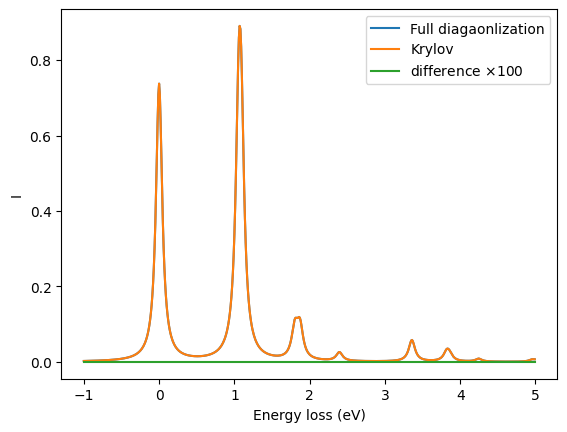

In [10]:
fig, ax = plt.subplots()

np.testing.assert_allclose(rixs, rixs_Krylov)

ax.plot(eloss, rixs, label='Full diagaonlization')
ax.plot(eloss, rixs_Krylov, label='Krylov')
ax.plot(eloss, 100*(rixs - rixs_Krylov), label=r'difference $\times100$')

ax.legend()
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')